In [1]:
# !pip install tokenizers
# !pip install transformers
# !pip install konlpy
# !pip install soynlp

# 모델_1 긍정/부정 분류에 사용해볼 전처리

mecab을 써서 토큰화한다.

불용어제거하지않고

wordpiece적용위치

=> 모델학습  
RNN이 아닌 Transfomer모델을 써볼것이다.

In [2]:
#시각화용 임포트 모음
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objs as go

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
import tensorflow as tf
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

#1. Naver Sentiment Movie Corpus v1.0 다운로드
train_file = tf.keras.utils.get_file('train.txt', 'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt')
train_text = open(train_file,'rb').read().decode(encoding='utf-8')

df_train = pd.DataFrame({
    'text':[ row.split('\t')[1] for row in train_text.split('\n')[1:] if row.count('\t')>0 ],
    'sentiment': [ int(row.split('\t')[2]) for row in train_text.split('\n')[1:] if row.count('\t')>0]
})

# 데이터 크기 지정
df_train = df_train[::10]

#널값있는지 확인
empty_string_exists = any(df_train['text'].apply(lambda x: x == ""))

if empty_string_exists:
    print("빈 문자열이 존재합니다.")
else:
    print("빈 문자열이 없습니다.")

#널값제거
#빈 문자열을 NaN 값으로 대체
df_train[{'text','sentiment'}].replace('', np.nan, inplace=True)

# NaN 값을 포함하는 행 제거
df_train.dropna( inplace=True)

print(df_train)



빈 문자열이 없습니다.
                                                     text  sentiment
0                                     아 더빙.. 진짜 짜증나네요 목소리          0
10                                       걍인피니트가짱이다.진짜짱이다♥          1
20              나름 심오한 뜻도 있는 듯. 그냥 학생이 선생과 놀아나는 영화는 절대 아님          1
30      엄포스의 위력을 다시 한번 깨닫게 해준 적.남 꽃검사님도 연기 정말 좋았어요! 완전...          1
40                                       단순하면서 은은한 매력의 영화          1
...                                                   ...        ...
149950                                   맥양 역시 언제 봐도 이쁘다.          1
149960                                               지루하다          0
149970                                     한번더보고싶은영화 너무좋음          1
149980             아, 진짜 웃긴다...프랑스 영화 정말 싫어했었는데 이 영화는 열외~          1
149990                                       이걸 영화라고 찎었냐?          0

[15000 rows x 2 columns]


In [3]:
# train 데이터 입력값(X)을 정제(Cleaning)
import re
from soynlp.normalizer import repeat_normalize

def clean_korean_text(text):
    # 특수 문자 및 숫자 제거
    text = re.sub(r'[^가-힣ㄱ-ㅎㅏ-ㅣ\s]', ' ', text)
    # 반복되는 자음, 모음 제거 (e.g., 'ㅋㅋㅋ' -> 'ㅋ')
    text = repeat_normalize(text, num_repeats=1)
    # 띄어쓰기 정규화 (연속된 공백 문자를 하나의 공백 문자로 변환)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


df_train['text']=df_train['text'].apply(lambda x:clean_korean_text(x))
df_train


,text,sentiment
0,아 더빙 진짜 짜증나네요 목소리,0
10,걍인피니트가짱이다 진짜짱이다,1
20,나름 심오한 뜻도 있는 듯 그냥 학생이 선생과 놀아나는 영화는 절대 아님,1
30,엄포스의 위력을 다시 한번 깨닫게 해준 적 남 꽃검사님도 연기 정말 좋았어요 완전 ...,1
40,단순하면서 은은한 매력의 영화,1
...,...,...
149950,맥양 역시 언제 봐도 이쁘다,1
149960,지루하다,0
149970,한번더보고싶은영화 너무좋음,1
149980,아 진짜 웃긴다 프랑스 영화 정말 싫어했었는데 이 영화는 열외,1


In [4]:
empty_string_exists = any(df_train['text'].apply(lambda x: x == ""))

if empty_string_exists:
    print("빈 문자열이 존재합니다.")
else:
    print("빈 문자열이 없습니다.")

#다시 널값 제거
# df_train['text'].apply(lambda x: x == "").drop(inplace=True)
df_train.drop(df_train[df_train['text'] == ""].index, inplace=True)

empty_string_exists = any(df_train['text'].apply(lambda x: x == ""))

if empty_string_exists:
    print("빈 문자열이 존재합니다.")
else:
    print("빈 문자열이 없습니다.")

빈 문자열이 존재합니다.
빈 문자열이 없습니다.


In [5]:
#정제된 텍스트를 벡터화하기전에 토큰화한다
from konlpy.tag import Mecab
# mecab=Mecab(dicpath=r'../../../../../../mecab/mecab-ko-dic/')
mecab=Mecab(dicpath=r'C:/mecab/mecab-ko-dic')

df_train['text']=df_train['text'].apply(lambda x: mecab.morphs(x))
df_train

,text,sentiment
0,"[아, 더, 빙, 진짜, 짜증, 나, 네요, 목소리]",0
10,"[걍인피니트가짱이다, 진짜, 짱, 이, 다]",1
20,"[나름, 심오, 한, 뜻, 도, 있, 는, 듯, 그냥, 학생, 이, 선생, 과, 놀...",1
30,"[엄, 포스, 의, 위력, 을, 다시, 한, 번, 깨닫, 게, 해, 준, 적, 남,...",1
40,"[단순, 하, 면서, 은은, 한, 매력, 의, 영화]",1
...,...,...
149950,"[맥, 양, 역시, 언제, 봐도, 이쁘, 다]",1
149960,"[지루, 하, 다]",0
149970,"[한번, 더, 보, 고, 싶, 은, 영화, 너무, 좋, 음]",1
149980,"[아, 진짜, 웃긴다, 프랑스, 영화, 정말, 싫, 어, 했었, 는데, 이, 영화,...",1


In [6]:
#토큰화된걸 ' ' 공백한칸을 기준으로 다시 합쳐준다.
df_train['text']=df_train['text'].apply(lambda x: ' '.join(i for i in x) )
df_train
#==> 교착어의 단점을 보완해준것이다.

,text,sentiment
0,아 더 빙 진짜 짜증 나 네요 목소리,0
10,걍인피니트가짱이다 진짜 짱 이 다,1
20,나름 심오 한 뜻 도 있 는 듯 그냥 학생 이 선생 과 놀아나 는 영화 는 절대 아님,1
30,엄 포스 의 위력 을 다시 한 번 깨닫 게 해 준 적 남 꽃 검사 님 도 연기 정말...,1
40,단순 하 면서 은은 한 매력 의 영화,1
...,...,...
149950,맥 양 역시 언제 봐도 이쁘 다,1
149960,지루 하 다,0
149970,한번 더 보 고 싶 은 영화 너무 좋 음,1
149980,아 진짜 웃긴다 프랑스 영화 정말 싫 어 했었 는데 이 영화 는 열외,1


리뷰의 최대 길이 : 226
리뷰의 평균 길이 : 40.96632159182576


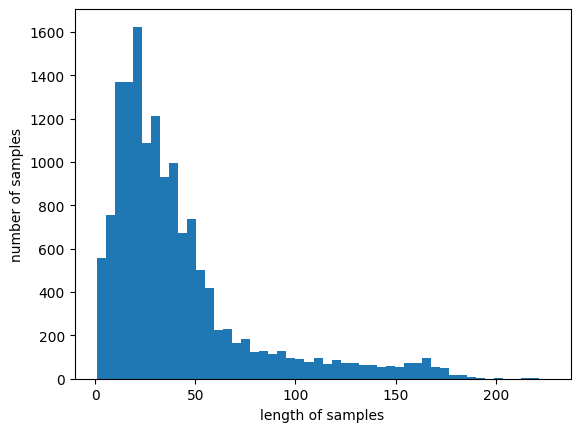

In [7]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(review) for review in df_train['text']))
print('리뷰의 평균 길이 :',sum(map(len, df_train['text']))/len(df_train['text']))
plt.hist([len(review) for review in df_train['text']], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

max_length = 64

word piece시작

In [8]:
# WordPiece 토큰화를 위한 사전 훈련된 모델 불러오기
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

In [9]:
#기존 인덱스를 지우면서 리셋한다.
df_train.reset_index(drop=True)

,text,sentiment
0,아 더 빙 진짜 짜증 나 네요 목소리,0
1,걍인피니트가짱이다 진짜 짱 이 다,1
2,나름 심오 한 뜻 도 있 는 듯 그냥 학생 이 선생 과 놀아나 는 영화 는 절대 아님,1
3,엄 포스 의 위력 을 다시 한 번 깨닫 게 해 준 적 남 꽃 검사 님 도 연기 정말...,1
4,단순 하 면서 은은 한 매력 의 영화,1
...,...,...
14871,맥 양 역시 언제 봐도 이쁘 다,1
14872,지루 하 다,0
14873,한번 더 보 고 싶 은 영화 너무 좋 음,1
14874,아 진짜 웃긴다 프랑스 영화 정말 싫 어 했었 는데 이 영화 는 열외,1


In [10]:
#전처리 함수정의
# df_train['text'].tolist() 리스트형태로 들어간다

train_encodings = tokenizer(df_train['text'].tolist(), truncation=True, padding=True, max_length=max_length) 



In [11]:
train_encodings.input_ids

[[101,
  9519,
  9074,
  9385,
  9708,
  119235,
  9715,
  119230,
  8982,
  9011,
  48549,
  9284,
  22333,
  12692,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [101,
  100,
  9708,
  119235,
  9718,
  9638,
  9056,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [101,
  8982,
  49543,
  9491,
  28188,
  9954,
  9153,
  9087,
  9647,
  9043,
  9120,
  8924,
  118729,
  9953,
  24017,
  9638,
  9428,
  24017,
  8898,
  9025,
  16985,
  16439,
  9043,
  42428,
  9043,
  9666,
  14423,
  9519,
  108578,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


In [12]:
# 입력 데이터로 변환
train_input_ids = np.array(train_encodings['input_ids'])
train_attention_mask = np.array(train_encodings['attention_mask'])
train_token_type_ids = np.array(train_encodings['token_type_ids'])

train_labels = np.array(df_train['sentiment'].tolist())



하나의 텍스트에 대한 텍스트 분류 유형(Single Text Classification)\
![버트구조](https://wikidocs.net/images/page/115055/apply1.PNG)

In [15]:
from transformers import TFBertForSequenceClassification,BertConfig
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# BERT 모델 불러오기
config = BertConfig.from_pretrained("bert-base-multilingual-cased", num_labels=2, hidden_dropout_prob=0.2)
bert_model  = TFBertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", config=config)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
bert_model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  177853440 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 177,854,978
Trainable params: 177,854,978
Non-trainable params: 0
_________________________________________________________________


In [17]:
# 입력 정의
input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="attention_mask")
token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="token_type_ids")

# BERT 출력 얻기
bert_output = bert_model(input_ids, attention_mask= attention_mask, token_type_ids=token_type_ids)


In [24]:
bert_output[]

IndexError: tuple index out of range

In [16]:

sequence_output = bert_output[0]

# 커스텀 레이어 정의
x = GlobalAveragePooling1D()(sequence_output)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
output = Dense(2, activation='softmax')(x)

# 모델 생성
custom_bert_model = Model(inputs=[input_ids, attention_mask, token_type_ids], outputs=output)

custom_bert_model.summary()


ValueError: Input 0 of layer "global_average_pooling1d" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 2)

In [ ]:
# 컴파일
custom_bert_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

early_stop=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=6)

# 모델 학습
custom_bert_model.fit(
    [train_input_ids, train_attention_mask, train_token_type_ids],
    train_labels,
    batch_size=128, epochs=20, validation_split=0.2, 
    callbacks=[early_stop]
)

In [33]:
from transformers import TextClassificationPipeline
# 예측용 파이프라인 생성
pipeline = TextClassificationPipeline(model=model, tokenizer=tokenizer, framework="tf")

# 예측 예시
example_text = "The movie was fantastic! I really enjoyed it."
predicted = pipeline(example_text)
print("Prediction:", predicted)

In [34]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
#테스트문장 입력
test = ['회식끝나고 집가는중','개꿀잼이네','진짜 너무 별로다.','ㅋㅋㅋㅋㅋㅋㅋㅋ재밌따']

#정제
clean_test_texts=[]
for i in test:
    clean_test_texts.append(clean_korean_text(i))

max_length = 64
# 텍스트 데이터 토큰화
tokenized_test_texts = [tokenizer.encode(text, max_length=max_length, pad_to_max_length=True) for text in clean_test_texts]
tokenized_test_texts

# 토큰화된 텍스트를 Numpy 배열로 변환
tokenized_test_texts = np.array(tokenized_test_texts)
tokenized_test_texts

#벡터화
x_test = pad_sequences(tokenized_test_texts,padding='post',maxlen=max_length) 

#예측
prediction = model.predict(x_test)  

for i in np.round(prediction):
    print(int(i))

1/1 [==============================] - 1s 561ms/step
0
1
0
1


# 서비스 테스트

In [35]:
#모델 불러오기
from tensorflow.keras.models import load_model
loaded_model= load_model('./wordpiece_test.h5')

# #저장된 vectorizer 불러오기
# import pickle
# with open('./lstm_tokenizer.pkl', 'rb') as f:
#     loaded_test_vectorizer = pickle.load(f)

In [37]:
# 카톡대화 불러와서 정제,(정규화코드)하는 함수
import re

def get_from_txt(txt):
    data= open(txt,"r", encoding='utf-8').read().split('\n')
    sentences=[]
    for line in data:
        pattern = r'\[(.*?)\]\s+\[(.*?)\]\s+(.+)'
        match = re.match(pattern, line)
        if match:
            name = match.group(1)  # 첫 번째 대괄호 안의 단어 추출
            time = match.group(2)  # 두 번째 대괄호 안의 단어 추출
            content = match.group(3)  # 대괄호 뒤의 내용 추출
            # print(name, time, content)
            temp=[name,time,content]
            sentences.append(temp)    
    return sentences

#함수확인
get_from_txt('sample.txt')

[['김찬란', '오후 10:01', '사진'],
 ['김찬란', '오후 9:38', 'https://youtube.com/watch?v=o1G7DWFFHso&feature=share'],
 ['김찬란', '오후 10:42', '사진'],
 ['김찬란', '오후 10:42', '사기치고다니는 한장규'],
 ['김하영', '오후 10:45', '이야'],
 ['김하영', '오후 10:46', '게임에서도 치네'],
 ['김찬란', '오후 10:46', '진짜 니말이 맞다 진짜 친구면 친구한테 민폐되기 싫어서 돈빌려달란 소리도 안한다'],
 ['김하영', '오전 12:25', '이모티콘'],
 ['김하영', '오전 12:35', '회식끝나고 집가는중'],
 ['김찬란', '오전 12:35', '음음 초밥집 회식은 어디서 하냐'],
 ['김하영', '오전 12:35', '우리 실장형네 직이 고기집해서 글로갔다'],
 ['김하영', '오전 12:36', '회식하면 맨날 돼지고기만 먹는다'],
 ['김찬란', '오전 12:36', 'ㅋㅋㅋㅋㅋㅋ케'],
 ['김하영', '오전 12:36', '이모티콘'],
 ['김찬란', '오전 12:36', '아 내수용 회식'],
 ['김찬란', '오전 12:36', '사진'],
 ['김하영', '오전 12:36', 'ㅋㅋㅋㅋ 그런거 아니고 애들이 여기가 맛있다고 여기서먹음'],
 ['김찬란', '오전 12:37', '고기 얘시하니까'],
 ['김찬란', '오전 12:37', '나도 고기가 먹고 싶군'],
 ['김하영', '오전 12:37', 'ㅋㅋㅋㅋ '],
 ['김찬란', '오전 12:37', '낼 사먹어야겠다'],
 ['김하영', '오전 12:37', '와라 엉아가 소고기 사줄께'],
 ['김찬란', '오전 12:37', '내가 사야지 씹새야 입벌려'],
 ['김찬란', '오전 12:37', '고기 들어간'],
 ['김찬란', '오전 12:38', '너는 내가 사주고 싶으니까 '],
 ['김찬란', '오전 12:38', '취직해서

In [38]:
#닉네임 입력단 
# target_name = str(input())
target_name = '김하영'
print(target_name)  #김하영 입력

김하영


In [68]:
# 저장된 모델 불러오기
# from tensorflow.keras.models import load_models
# model= load_models('4_6_DNN 토큰화수정.h5')


#입력된 이름의 '대화내역만' 담기
received_texts= []
for i in get_from_txt('sample.txt'): 
    if i[0] == target_name:
        received_texts.append( i[2] )
        
# 이모티콘, 사진, 샵검색 제거 
clean_received_texts2 = []
for i in received_texts:
    if '샵검색:' not in i: 
        if "이모티콘" not in i:
            if '사진' not in i:
                clean_received_texts2.append(str(i))

#=========== 이쯤에서 답장시간 계산기 구현   =======================
          
          
#텍스트 정제  
clean_received_texts2= [clean_korean_text(i) for i in clean_received_texts2]
clean_received_texts2

# 텍스트 데이터 토큰화
tokenized_test_texts = [tokenizer.encode(text, max_length=max_length, pad_to_max_length=True) for text in clean_received_texts2]
tokenized_test_texts

# 토큰화된 텍스트를 Numpy 배열로 변환
tokenized_test_texts = np.array(tokenized_test_texts)
tokenized_test_texts

# 벡터데이터 변환
x_test = pad_sequences(tokenized_test_texts,padding='post',maxlen=64) 

# 모델을 사용하여 예측 수행
predictions = loaded_model.predict(x_test)
#예측 결과 출력 (긍정: 1, 부정: 0)
print(predictions.squeeze().tolist()) #차원을 축소하고 리스트객체로 변환

cnt0=0;cnt1=0; cnt2=0
for i in predictions.squeeze().tolist():
    if i <= 0.45:
        cnt0+=1
    elif i >= 0.55:
        cnt1+=1
    else :
        cnt2+=1
        
#부정과 긍정문의 갯수
print('부정문과 긍정문의 갯수:',cnt0,cnt1)
print('중립문장의 갯수:',cnt2)

#긍정과 부정의 비율( 긍정문의 수 / 부정문의 수)
print('긍정과 부정의 비율: ',cnt1/cnt0)
#숫자가 1이상이고 높을수록 긍정적이다.

6/6 [==============================] - 0s 7ms/step
[0.42015233635902405, 0.15778325498104095, 0.4034382998943329, 0.15830516815185547, 0.2756638824939728, 0.23274767398834229, 0.5671480298042297, 0.25340867042541504, 0.4362293481826782, 0.4002711772918701, 0.6111466884613037, 0.06004936248064041, 0.1837492287158966, 0.1312265843153, 0.2406095564365387, 0.08809877932071686, 0.3380661606788635, 0.17884549498558044, 0.544122040271759, 0.5671480298042297, 0.3253222107887268, 0.34540876746177673, 0.34540876746177673, 0.4286506474018097, 0.5671480298042297, 0.28317803144454956, 0.5671480298042297, 0.11938949674367905, 0.4006653428077698, 0.19541098177433014, 0.12212876230478287, 0.31381163001060486, 0.3801400661468506, 0.3815697431564331, 0.5671480298042297, 0.4159267246723175, 0.4814023971557617, 0.3980425298213959, 0.24305537343025208, 0.3207646906375885, 0.12008189409971237, 0.32288381457328796, 0.5671480298042297, 0.5671480298042297, 0.42395874857902527, 0.4516054093837738, 0.19916307926

In [ ]:
clean_received_texts2